In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier. Now our loss function can't be the residuals. Our options are "deviance", or "exponential". Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.

# *** It's best to update this table for the drill 
#  at the end of the lesson.  ***

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

### Evaluation of Model - Confusion Matrix Plot

based on the example here:

https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

In [4]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


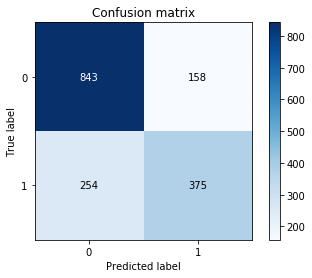

In [5]:
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


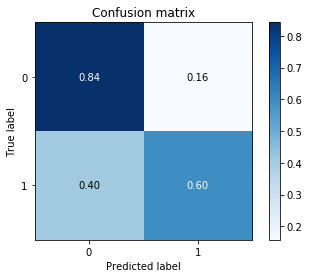

In [6]:
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],True)

### Accuracy

In [7]:
clf.score(X_test, y_test)

0.747239263803681

### Precision

In [8]:
y_pred = clf.predict(X_test)
precision_score(y_test,y_pred)

0.7035647279549718

### Recall

In [9]:
recall_score(y_test,y_pred)

0.5961844197138315

Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

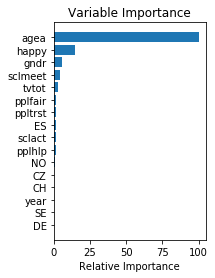

In [10]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, but there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

You can learn more about the parameters for the gradient boost model [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and update the **params** table featured earlier, before we initialized and fit the model.

A few parameters to tune could be:
 - learning_rate
 - max_depth
 - n_estimators
 - loss
 - subsample
 - min_samples_split
 
You can then use the same metrics to evaluate your results.
          
Have fun!

### ----------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
# Data exploration
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8147 entries, 0 to 8593
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cntry    8147 non-null   object 
 1   idno     8147 non-null   float64
 2   year     8147 non-null   int64  
 3   tvtot    8147 non-null   float64
 4   ppltrst  8147 non-null   float64
 5   pplfair  8147 non-null   float64
 6   pplhlp   8147 non-null   float64
 7   happy    8147 non-null   float64
 8   sclmeet  8147 non-null   float64
 9   sclact   8147 non-null   float64
 10  gndr     8147 non-null   float64
 11  agea     8147 non-null   float64
 12  partner  8147 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 891.1+ KB


In [12]:
# Feature Selection
df['ppl'] = df['ppltrst'] * df['pplfair'] * df['pplhlp']
df['scl'] = df['sclmeet'] * df['sclact']

X = df[['ppl', 'scl', 'agea', 'happy', 'gndr', 'tvtot']].copy()
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)
y = df['partner'] - 1

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size= 0.2)

In [13]:
# Tune hyper-parameters for gridsearchcv
params = {'n_estimators': [500, 600, 700],
          'max_depth': [2, 4],
          'loss': ['deviance', 'exponential'],
          'learning_rate': [.05, .1, .5],
          'subsample': [.5, 1],
          'min_samples_split': [2, 4]}


In [14]:
gbc = ensemble.GradientBoostingClassifier()
grid = GridSearchCV(gbc, params, n_jobs=8, verbose=3).fit(X_train, Y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   49.7s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done 720 out of 720 | elapsed:  5.3min finished


In [15]:
grid.best_params_

{'learning_rate': 0.05,
 'loss': 'deviance',
 'max_depth': 2,
 'min_samples_split': 2,
 'n_estimators': 500,
 'subsample': 1}

In [19]:
best_model = grid.best_estimator_

In [20]:
best_model.score(X_test, Y_test)

0.7711656441717791

In [17]:
y_pred = grid.predict(X_test)
precision_score(Y_test,y_pred)

0.8147208121827412